```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. https://github.com/ResidentMario/missingno
2. https://www.freecodecamp.org/news/how-machines-make-predictions-finding-correlations-in-complex-data-dfd9f0d87889/
3. https://www.scikit-yb.org/en/latest/quickstart.html#walkthrough

```

# Exploring Data (EDA)
By understanding the business and the data, you are able to create better models and have a better impact on their business. EDA gives us a feel for the data, but also is a great excuse to meet and discuss issues with business units that control that data.

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
df = get_dataset('titanic3')

## Data Size

In [5]:
df.shape

(1309, 14)

## Summary Stats

In [6]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [7]:
# First and last columns
df.describe().iloc[:, [0, -1]]

,pclass,body
count,1309.000000,121.000000
mean,2.294882,160.809917
std,0.837836,97.696922
min,1.000000,1.000000
25%,2.000000,72.000000
50%,3.000000,155.000000
75%,3.000000,256.000000
max,3.000000,328.000000


## Histogram
A histogram is a great tool to visualize numeric data.

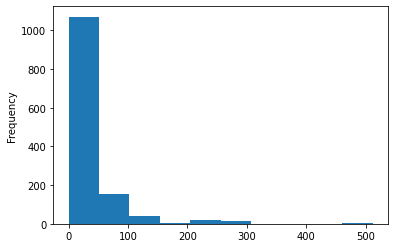

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
df.fare.plot(kind="hist", ax=ax)
fig.savefig("images/eda_histogram.png", dpi=300)

In [9]:
y = df.survived
X = df.drop(columns='survived')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


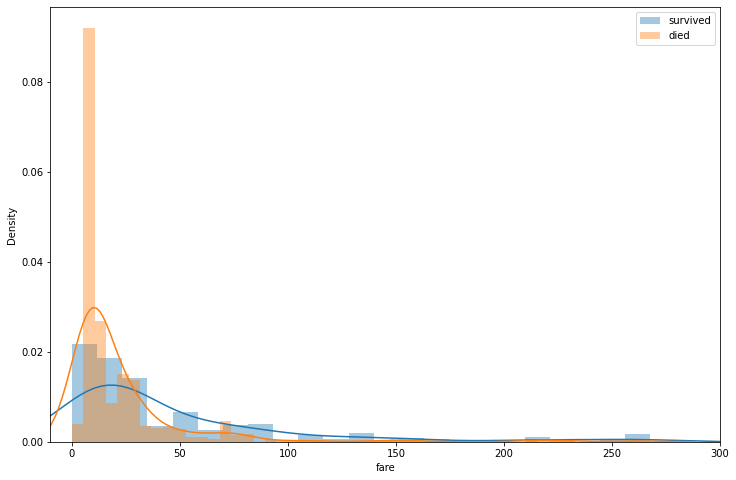

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
mask = y == 1
ax = sns.distplot(X[mask].fare, label='survived')
ax = sns.distplot(X[~mask].fare, label='died')
ax.set_xlim(-10, 300)
ax.legend()
fig.savefig("images/eda_histogram2.png", dpi=300, bbox_inches='tight')

## Density Distribution Plots

In [ ]:
# The function below can be simplified
# it does not cover object type (string)

In [78]:
MIN_OBSERVATIONS_IN_CLASS = 7
# there need to be at least 655 not-na values in a column to consider it as a column that can be analysed
# it is 50% of the data size + 1
N_NOT_NULL = 655
from pandas.api.types import is_datetime64_any_dtype as is_datetime

def validate_column(vals, n_not_null=N_NOT_NULL, min_observations_in_class=MIN_OBSERVATIONS_IN_CLASS):
    '''The function checks whether a columns can be modeled using ML models. It also classifies column into
    type of applicable models - binary, multiclass, regression or unknown.

    Args:
        vals: column to validate
        n_not_null: columns needs to have at least n_not_null values in order to be valid
        min_observations_in_class: the function will preserve only groups that have at least 
            `min_observations_in_class` observations

    Returns:
        boolean, str: assessment whether column is valid and either its classification or reason 
            for not being a valid column
    '''
    valid, reason = True, ''
    vals_not_na = vals.dropna()
    if vals_not_na.shape[0] < n_not_null:
        valid, reason = False, f'Not enough values ({vals_not_na.shape[0]}) provided, required: {n_not_null}'
        return valid, reason
    if is_datetime(vals_not_na):
        valid, reason = True, 'datetime'
        return valid, reason

    # determine column type
    n_unique = vals_not_na.unique().shape[0]
    if n_unique <= 1:
        valid, reason = False, 'Not enough classes (0 or 1).'
    elif n_unique > vals_not_na.shape[0]*0.9 and (vals_not_na.dtype != 'float64' and vals_not_na.dtype != 'int64'):
        valid, reason = True, 'identifier'
    elif n_unique == 2:
        valid, reason = True, f'binary'
    # 17 is somewhat arbitrary
    elif n_unique > 2 and ((n_unique < 17 and vals_not_na.dtype == 'float64') or \
                           (vals_not_na.dtype != 'float64' and vals_not_na.dtype != 'int64')):
        valid, reason = True, 'multiclass'
    elif n_unique > 2 and (vals_not_na.dtype == 'float64' or vals_not_na.dtype == 'int64'):
        valid, reason = True, 'regression'
    else:
        valid, reason = False, 'Type not known.'

    # second pass - this time we drop small groups for binary and multiclass variables
    # and check whether the type changed
    if reason == 'binary' or reason == 'multiclass':
        vals_not_na = drop_infrequent_groups(vals_not_na, min_observations_in_class)
        n_unique = vals_not_na.unique().shape[0]
        if n_unique <= 1:
            valid, reason = False, 'Not enough classes (0 or 1).'
        elif n_unique == 2:
            valid, reason = True, 'binary'
        else:  # otherwise the type - multiclass is preserved
            pass

    return valid, reason

In [80]:
def drop_infrequent_groups(vals, min_observations_in_class=MIN_OBSERVATIONS_IN_CLASS):
    '''For vals, count the occurrence of unique values in groups and, if the count is below
    min_observations_in_class - replace these values with pd.NA.

    Args:
        vals: group values
        min_observations_in_class: threshold of 'infrequency'
    Returns:
        pd.Series: series with infrequent groups replaced by NAs
    '''
    type_ = vals.dtype
    vc = vals.value_counts()
    infrequent_entries = vc.loc[vc < min_observations_in_class].index.tolist()
    vals = vals.replace(infrequent_entries, pd.NA).dropna().astype(type_)  # to preserve the type
    return vals

In [86]:
df1 = df.copy()
df1.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [87]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [88]:
df1.ticket.value_counts()

CA. 2343           11
CA 2144             8
1601                8
3101295             7
S.O.C. 14879        7
                   ..
SW/PP 751           1
27267               1
SOTON/OQ 392076     1
Fa 265302           1
C.A. 15185          1
Name: ticket, Length: 939, dtype: int64

In [89]:
df1.drop(columns=['ticket'], inplace=True)

In [90]:
column_types = df1.apply(validate_column, axis=0, n_not_null=N_NOT_NULL, min_observations_in_class=MIN_OBSERVATIONS_IN_CLASS).T.set_axis(['analysable', 'column_type'], axis=1)
column_types

,analysable,column_type
pclass,True,regression
survived,True,binary
name,True,identifier
sex,True,binary
age,True,regression
sibsp,True,regression
parch,True,regression
fare,True,regression
cabin,False,"Not enough values (295) provided, required: 655"
embarked,True,multiclass


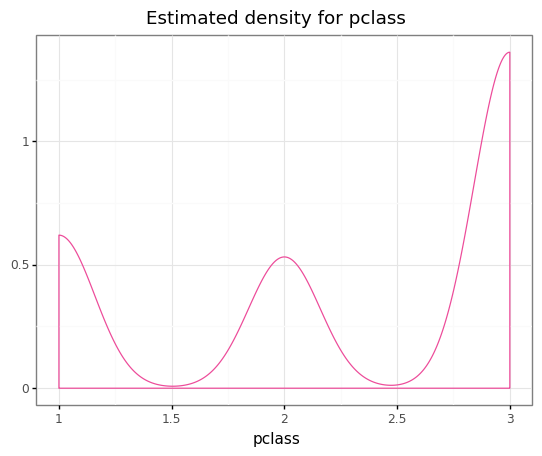

<ggplot: (8738435908997)>


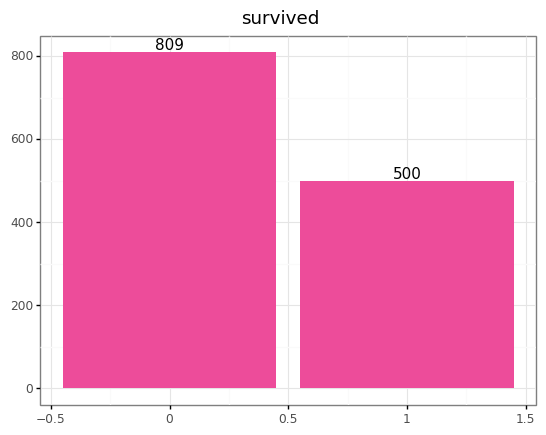

<ggplot: (8738435727885)>


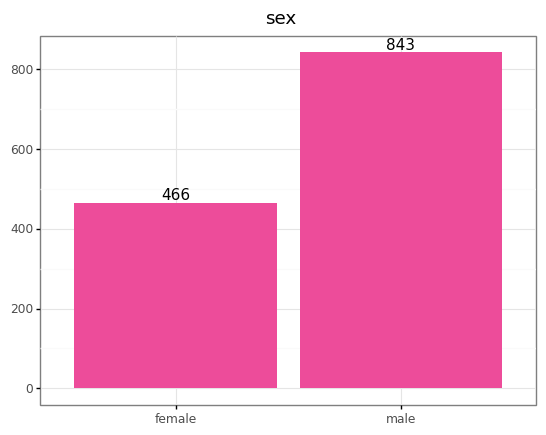

<ggplot: (8738435892005)>


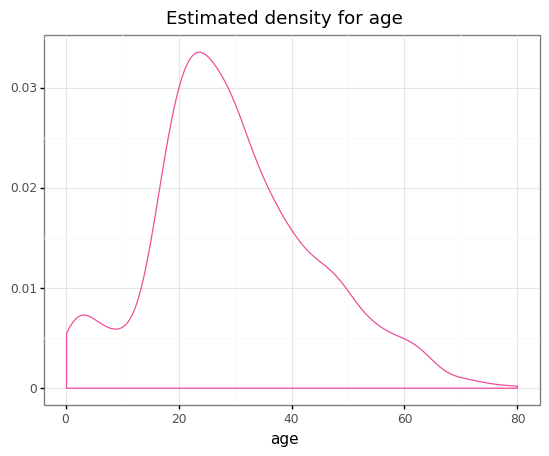

<ggplot: (8738435811612)>


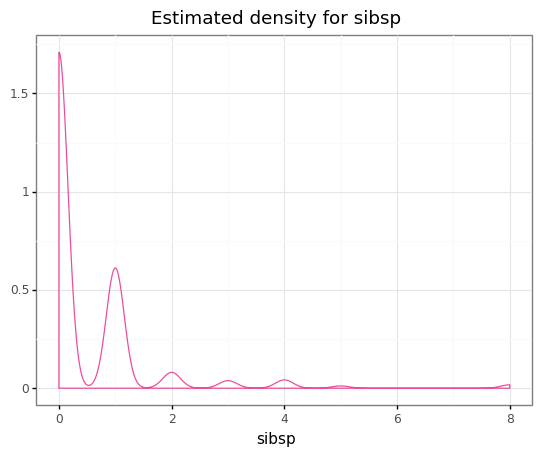

<ggplot: (8738435767134)>


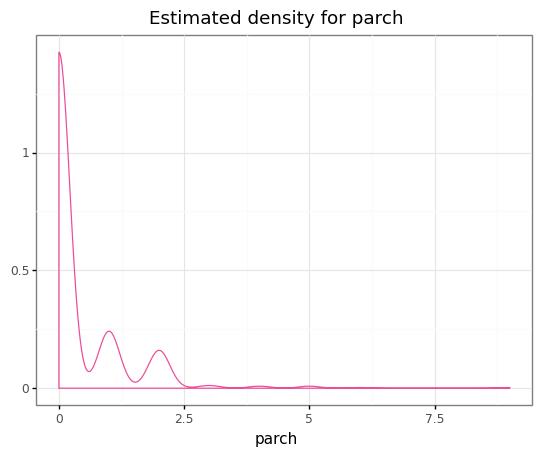

<ggplot: (8738445855988)>


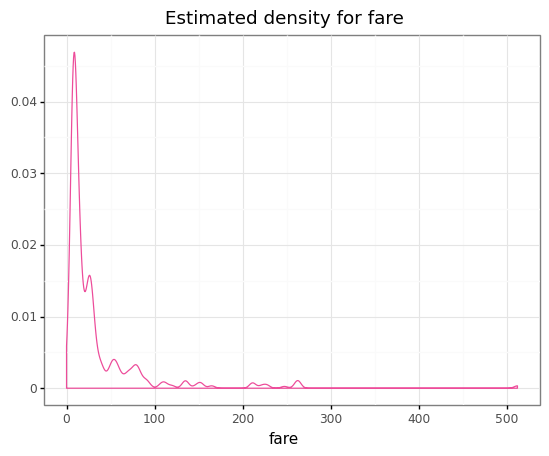

<ggplot: (8738435597373)>


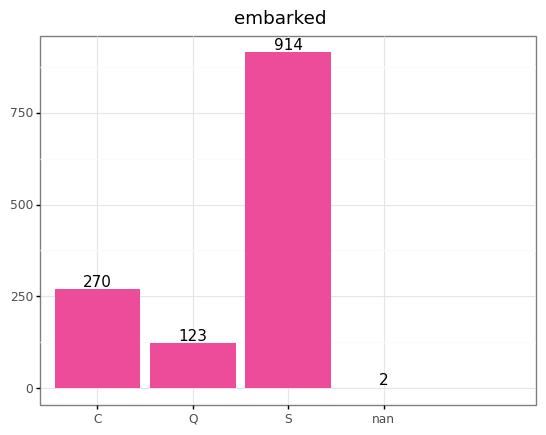

<ggplot: (8738435578649)>


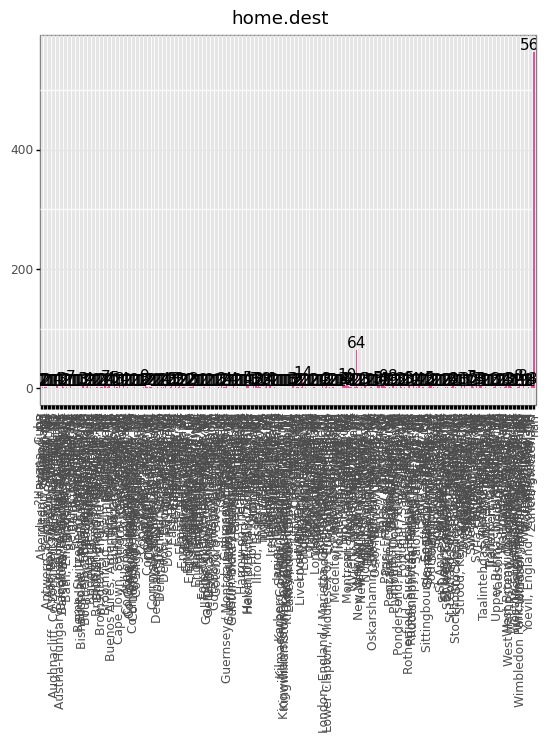

<ggplot: (8738435758430)>


In [91]:
import plotnine as pln
import warnings
from IPython.core.display import display, HTML

warnings.simplefilter(action='ignore')
for i, (col_name, vals) in enumerate(df1.iteritems()):
    col_name_clean = col_name#.replace('_', ' ').upper()
    col_type = column_types.loc[col_name]['column_type']

    if col_type in ('binary', 'multiclass', 'Not enough classes (0 or 1).'):
        p1 = (pln.ggplot(df1, pln.aes(x=col_name)) +
              pln.geom_bar(fill='#ed4c9a') +
              pln.geom_text(pln.aes(y='stat(count)', label='stat(count)'), stat='count', va='bottom') +
              pln.labs(title=col_name_clean, x='', y='') +
              pln.theme_bw()
              )
        if df1[col_name].unique().shape[0] > 10:
            p1 = p1 + pln.theme(axis_text_x=pln.element_text(angle=90))
    elif col_type == 'regression':
        p1 = (pln.ggplot(df1, pln.aes(x=col_name)) +
              pln.geom_density(color='#ed4c9a') +
              pln.labs(title=f'Estimated density for {col_name_clean}', x=col_name_clean, y='') +
              pln.theme_bw()
              )
    else:
        continue
    display(HTML(f'<h1><center>{col_name_clean}</center></h1>'))
    print(p1)

    display(HTML('<hr>'))

## Scatter Plot
A scatter plot shows the relationship between two numeric columns.

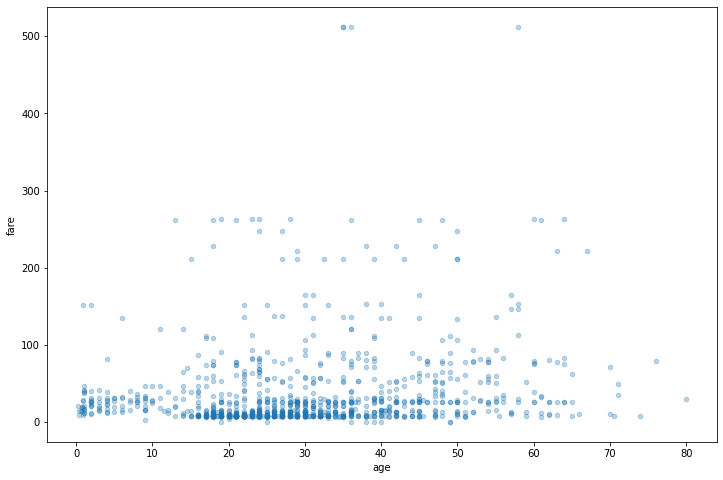

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
X.plot.scatter(x="age", y="fare", ax=ax, alpha=0.3)
fig.savefig("images/eda_scatter.png", dpi=300)

## Joint Plot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


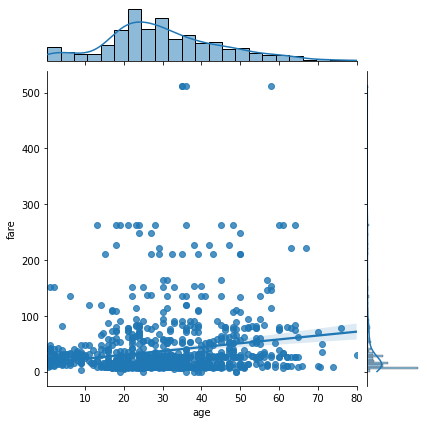

In [12]:
from seaborn import jointplot

# https://seaborn.pydata.org/generated/seaborn.jointplot.html

p = jointplot("age", "fare", data=X, kind="reg")
p.savefig("images/eda_joint_plot.png", dpi=300)

## Pair Grid
This plot is a matrix of columns and kernel density estimations. To color by a column from a DataFrame, use the `hue` parameter. By coloring with the target, we can see if features have different effects on the target.

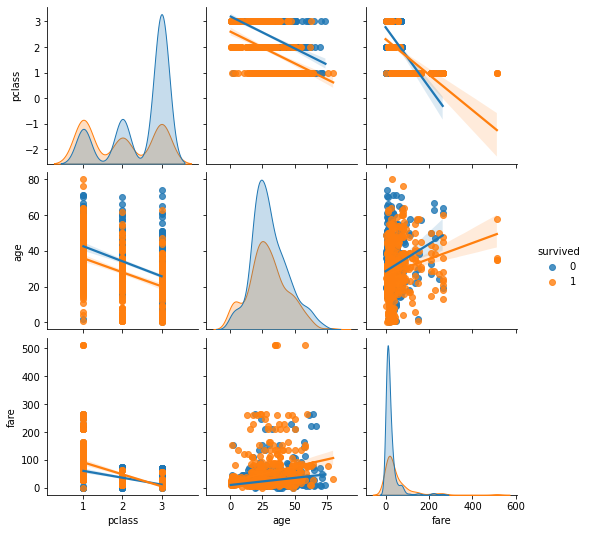

In [13]:
from seaborn import pairplot

vars = ["pclass", "age", "fare"]
p = pairplot(df, vars=vars, hue="survived", kind="reg")
p.savefig("images/eda_pair_grid.png", dpi=300)

## Box and Violin Plots
Plots to visualize distributions.

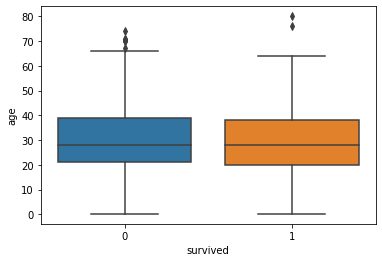

In [14]:
from seaborn import boxplot

boxplot(x="survived", y="age", data=df)
p.savefig("images/eda_box_plot.png", dpi=300)

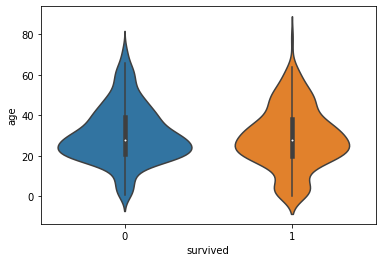

In [15]:
from seaborn import violinplot

violinplot(x="survived", y="age", data=df)
p.savefig("images/eda_violin_plot.png", dpi=300)

## Comparing Two Ordinal Values
Here is pandas code to compare two ordinal categories. I’m simulating that by binning age into ten quantiles, and pclass into three bins. The plot is normalized so it fills all of the vertical area. This makes it easy to see that in the 40% quantile most of the tickets were in 3rd class.

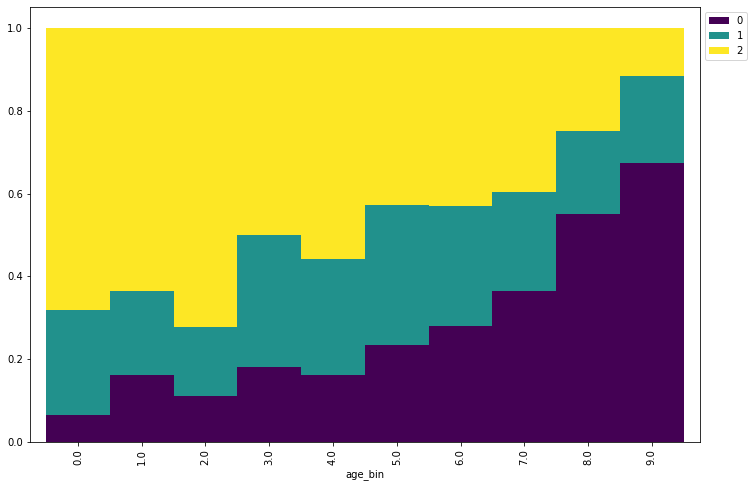

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
(
    X.assign(
        age_bin=pd.qcut(
            X.age, q=10, labels=False
        ),
        class_bin=pd.cut(
            X.pclass, bins=3, labels=False
        ),

    )
    #.groupby(["age_bin", "class_bin"])
    #.size()
    #.unstack()
    .pipe(lambda df: pd.crosstab(df.age_bin, df.class_bin)) # replaces 3 lines above
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)
fig.savefig("images/eda_two_ordinal.png", dpi=300)

## Correlation

In [17]:
# Pearson correlation
X.age.corr(X.fare)

0.17873932314646118

In [18]:
X.corr()

,pclass,age,sibsp,parch,fare,body
pclass,1.000000,-0.408106,0.060832,0.018322,-0.558629,-0.034642
age,-0.408106,1.000000,-0.243699,-0.150917,0.178739,0.058809
sibsp,0.060832,-0.243699,1.000000,0.373587,0.160238,-0.099961
parch,0.018322,-0.150917,0.373587,1.000000,0.221539,0.051099
fare,-0.558629,0.178739,0.160238,0.221539,1.000000,-0.043110
body,-0.034642,0.058809,-0.099961,0.051099,-0.043110,1.000000


In [19]:
X.corr().iloc[:, :2]

,pclass,age
pclass,1.000000,-0.408106
age,-0.408106,1.000000
sibsp,0.060832,-0.243699
parch,0.018322,-0.150917
fare,-0.558629,0.178739
body,-0.034642,0.058809


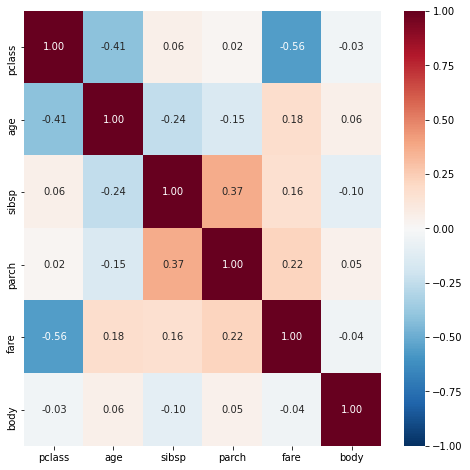

In [20]:
from seaborn import heatmap

fig, ax = plt.subplots(figsize=(8, 8))
ax = heatmap(X.corr(), fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1,)
fig.savefig("images/eda_correlation1.png", dpi=300)

In [59]:
# Missing values?
df.isnull().mean()#.value_counts()

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

In [60]:
df1 = df.copy()

In [62]:
# Missing values?
df1.isnull().mean()#.value_counts()

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

In [63]:
# There cannot be missing values in the dataset for the cluster map
# https://stackoverflow.com/questions/62044918/how-to-fix-seaborn-clustermap-matrix
X_fields = df1.loc[:, ~df1.columns.isin(['age', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'])].columns
y_field = 'survived'

In [64]:
X_fields

Index(['pclass', 'survived', 'name', 'sex', 'sibsp', 'parch', 'ticket'], dtype='object')

In [65]:
plot_columns = X_fields.union(['survived'])
plot_columns

Index(['name', 'parch', 'pclass', 'sex', 'sibsp', 'survived', 'ticket'], dtype='object')

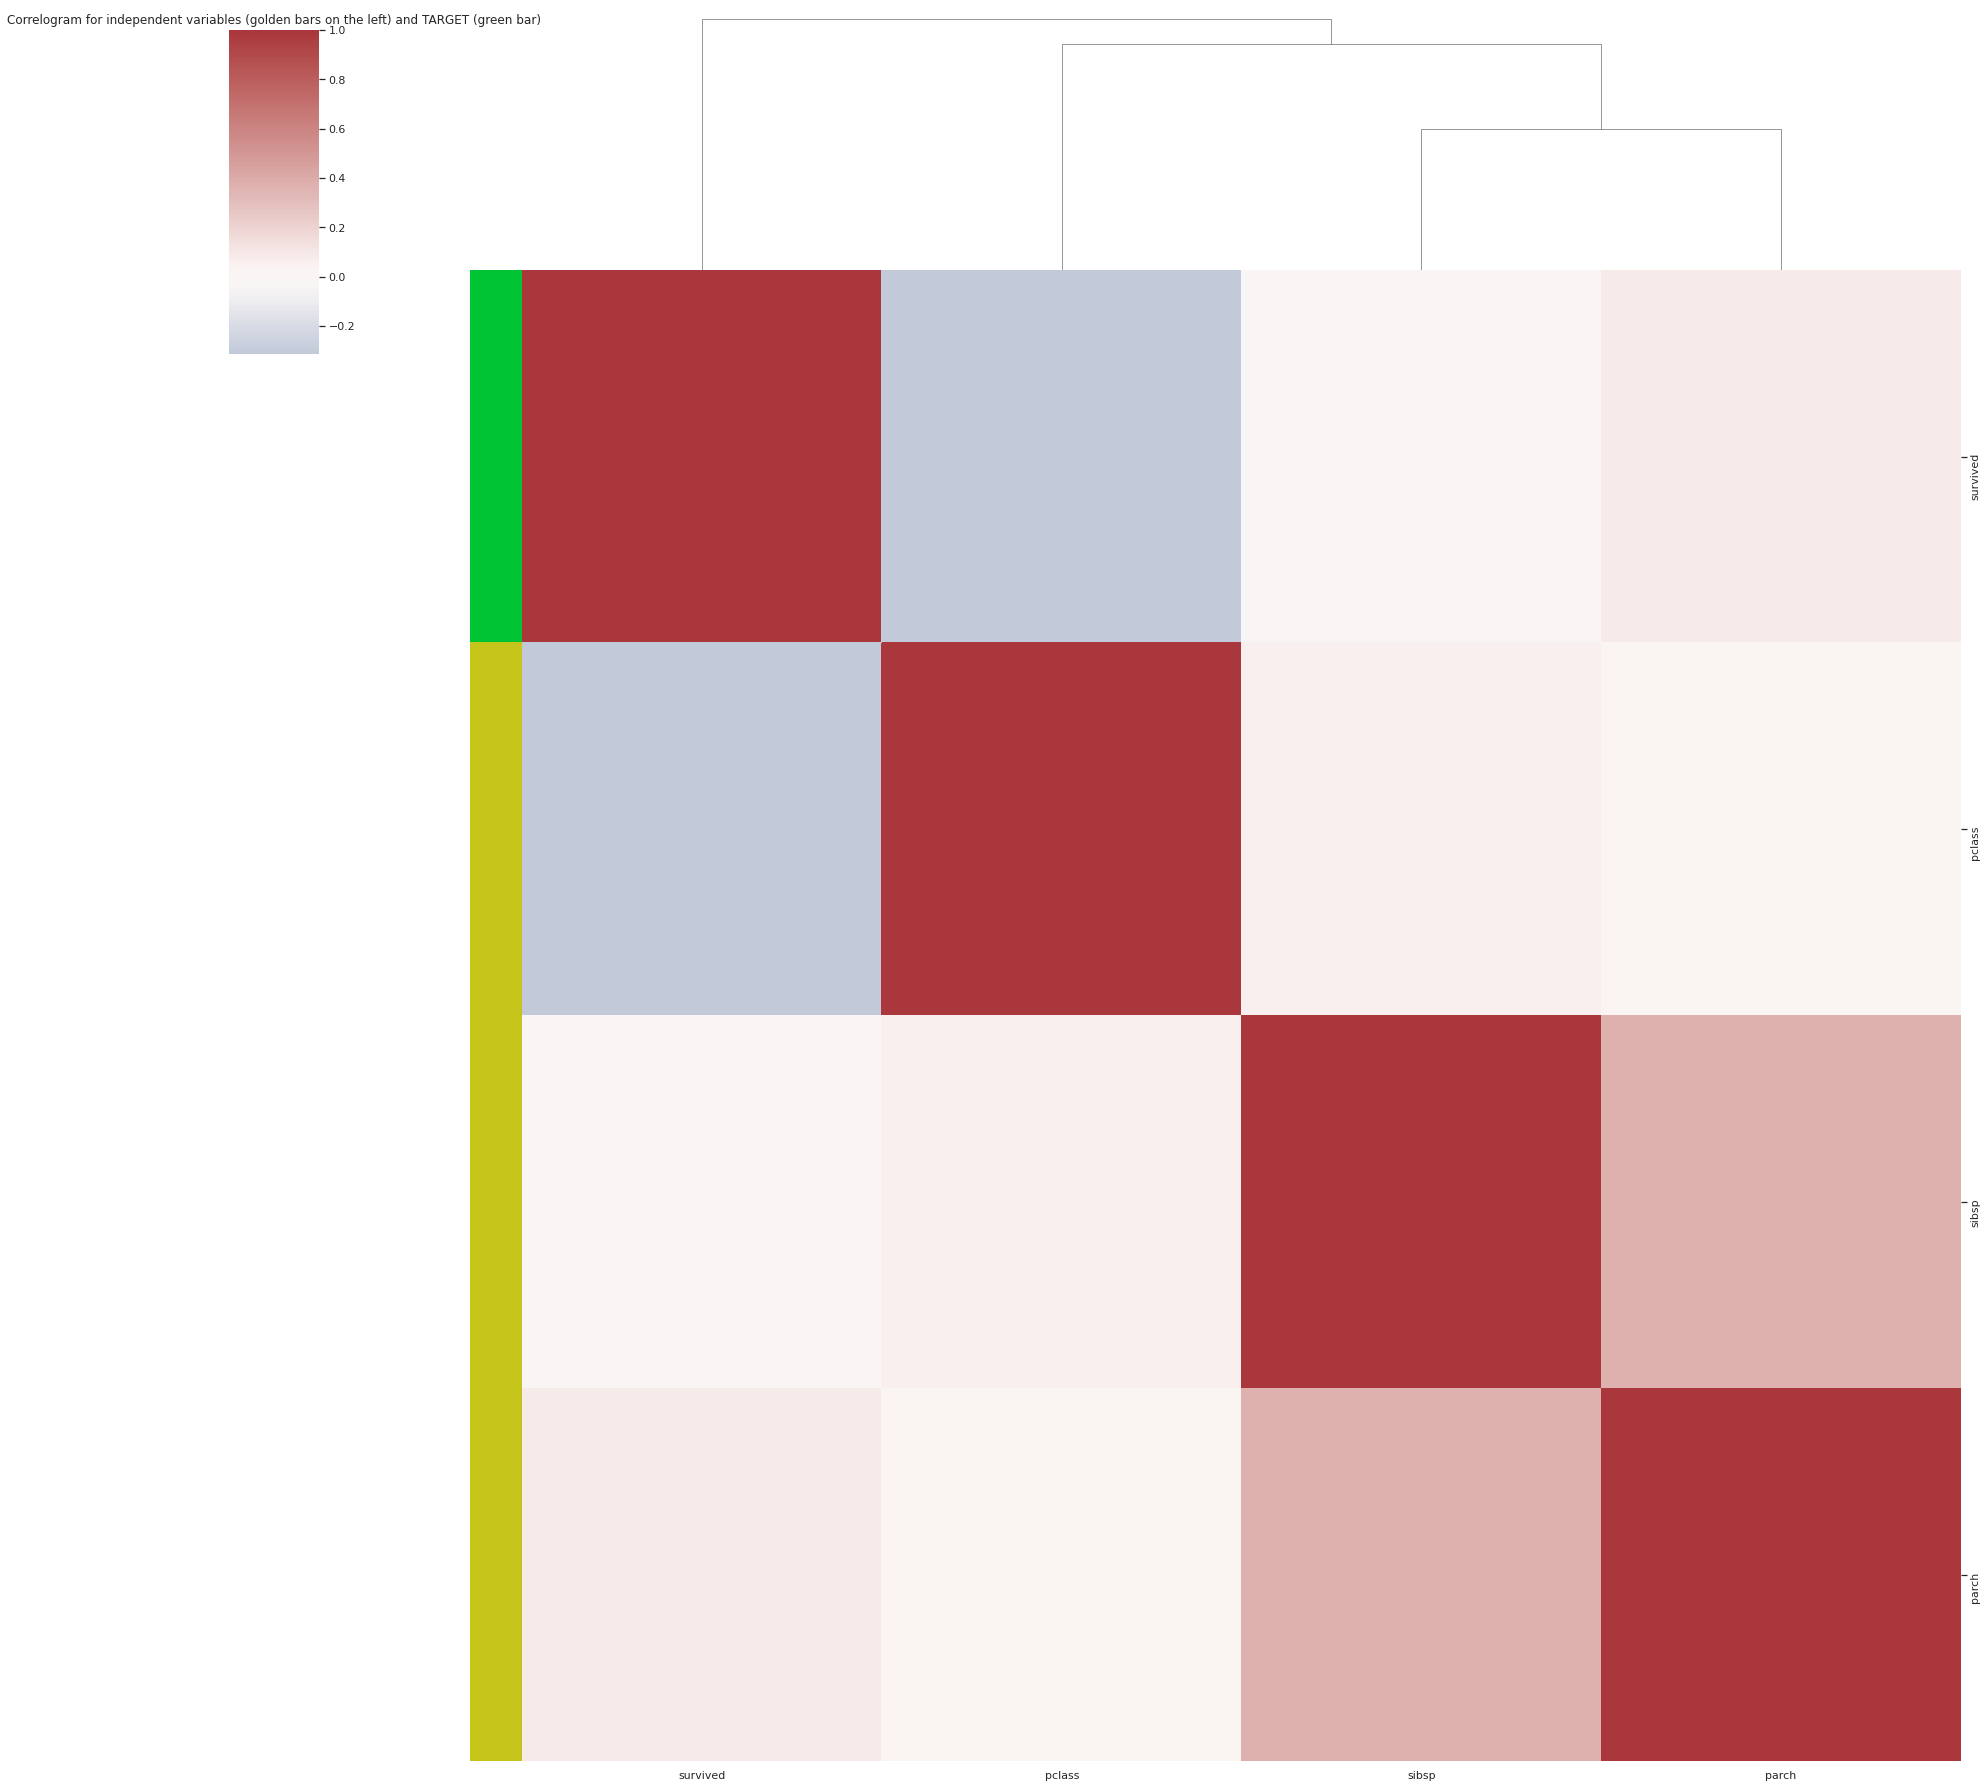

In [66]:
sns.set_theme(style='white')
correlogram = sns.clustermap(df1[X_fields].corr(), center=0, cmap='vlag',
                             figsize=(25, 25), dendrogram_ratio=0.15,
                             row_colors=['#00c434' if col == 'survived' else '#c4c41b' for col in df1.columns]
                            )
correlogram.ax_row_dendrogram.remove()
plt.title('Correlogram for independent variables (golden bars on the left) and TARGET (green bar)')
plt.show()

## RadViz
A RadViz plot shows each sample on a circle, with the features on the circumference. The values are normalized, and you can imagine that each figure has a spring that pulls samples to it based on the value. This is one technique to visualize separability between the targets.

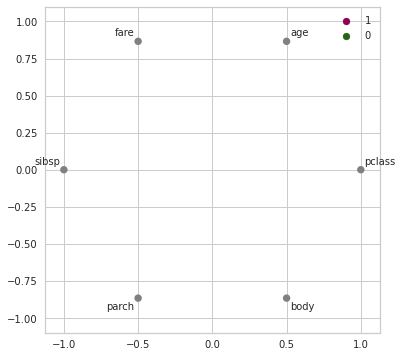

In [76]:
from pandas.plotting import radviz

vars = ["pclass", "age", "fare", "sibsp", "parch", "body", "survived"]
Xnum = df[vars].copy()
fig, ax = plt.subplots(figsize=(6, 6))
radviz(Xnum, "survived", ax=ax, colormap="PiYG")
fig.savefig("images/eda_radviz.png", dpi=300)

## Parallel Coordinates
For multivariate data, you can use a parallel coordinates plot to see clustering visually.

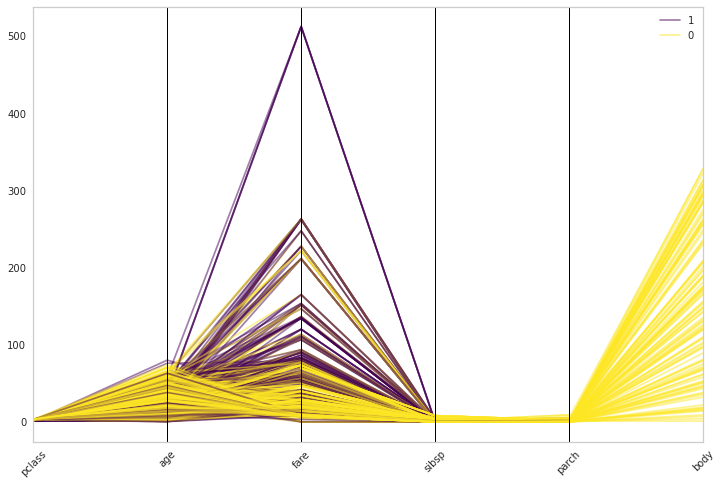

In [78]:
from pandas.plotting import parallel_coordinates

fig, ax = plt.subplots(figsize=(12, 8))
parallel_coordinates(Xnum, "survived", ax=ax, colormap="viridis", alpha=0.5,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.savefig("images/eda_parallel.png", dpi=300)